In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.datasets import make_moons

import tensorflow as tf
from svm_tensorflow import *

In [6]:
data = make_moons(3000, noise=0.05)
x, y = data

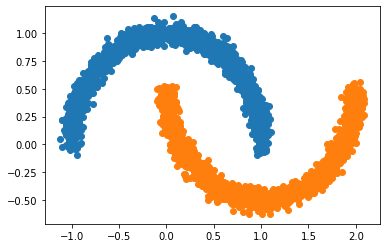

In [7]:
plt.scatter(x[y==0,0], x[y==0,1])
plt.scatter(x[y==1,0], x[y==1,1])

In [8]:
y = tf.one_hot(y, depth=2, on_value=1, off_value=0).numpy()

In [9]:
x, y = shuffle(x, y)

n_train = int(0.8 * len(x))
train_x, train_y = x[:n_train], y[:n_train]
valid_x, valid_y = x[n_train:], y[n_train:]

In [10]:
Bone = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(64, activation="relu"),
])

In [11]:
model = SVMTrainer(num_class=2, bone=Bone)

In [12]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [13]:
model.compile(optimizer="adam", metrics=METRICS)

In [14]:
epochs = 200

show_progress = ShowProgress(epochs)
best_weight = BestModelWeights()

In [15]:
history = model.fit(train_x, train_y,
                    epochs=epochs, validation_data=(valid_x, valid_y),
                    callbacks=[best_weight, show_progress],
                    verbose=0
                   )

  0%|          | 0/200 [00:00<?, ?it/s]


Best weights is set, Best Epoch was : 199



In [17]:
print(model.evaluate(valid_x, valid_y))

19/19 [==============================] - 0s 4ms/step - loss: 0.1685 - tp: 292.0000 - fp: 6.0000 - tn: 300.0000 - fn: 2.0000 - accuracy: 0.9867 - precision: 0.9799 - recall: 0.9932 - auc: 0.9996 - prc: 0.9996
[0.16851653158664703, 292.0, 6.0, 300.0, 2.0, 0.9866666793823242, 0.9798657894134521, 0.9931972622871399, 0.9995887279510498, 0.99956876039505]


In [20]:
def plot_metrics(history):
    plt.figure(figsize=(12, 10))
    metrics = ['loss', 'prc', 'accuracy', 'fp', 'precision', "tp", "recall", "tn", "auc", "fn"]
    
    for n, metric in enumerate(metrics):
        
        name = metric.replace("_"," ").capitalize()
        plt.subplot(5, 2, n+1)
        
        plt.plot(history.epoch,
                 history.history[metric],
                 color=colors[0],
                 label='Train')
        
        plt.plot(history.epoch,
                 history.history['val_'+ metric],
                 color=colors[1],
                 #linestyle="--",
                 label='Val')
        
        plt.xlabel('Epoch')
        plt.ylabel(name)

        plt.legend();


def plot_roc(name, labels, predictions, **kwargs):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    auc = sklearn.metrics.auc(fpr, tpr)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=name + f" ( AUC = {round(auc, 3)} )", linewidth=2, **kwargs)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.grid(True)


def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()


def plot_cm(name, labels, predictions, p=0.5):
    cm = sklearn.metrics.confusion_matrix(labels, predictions > p)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(name + ' Confusion matrix @ {:.2f}'.format(p))
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')

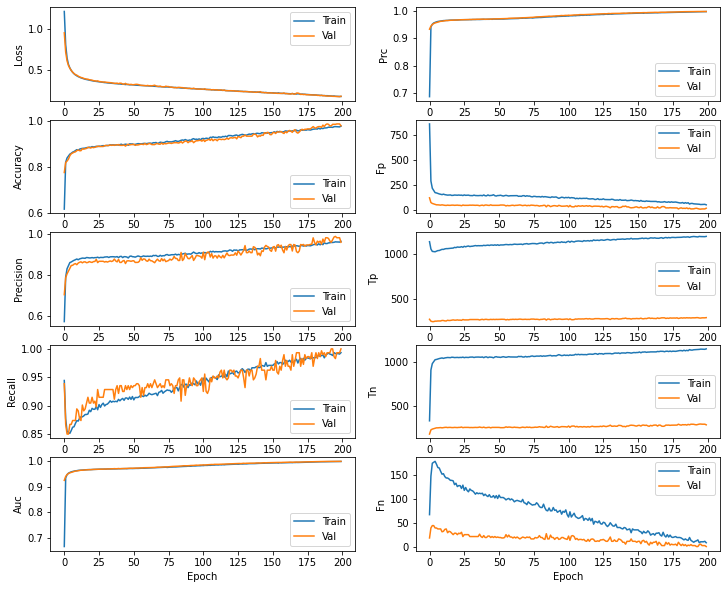

In [22]:
plot_metrics(history)

1250/1250 [==============================] - 2s 2ms/step


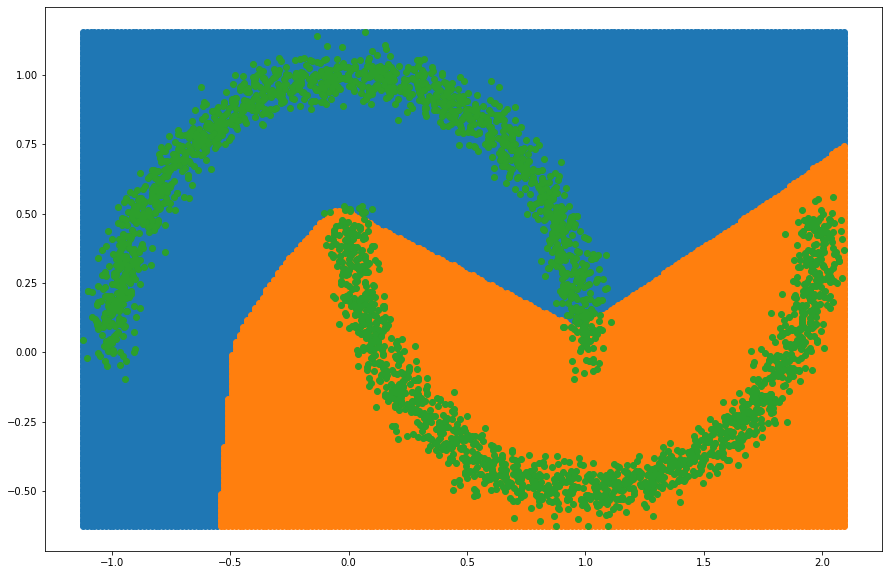

In [24]:
Min = x.min(axis=0)
Max = x.max(axis=0)

a = np.linspace(Min[0], Max[0], 200)  
b = np.linspace(Min[1], Max[1], 200)  
xa, xb = np.meshgrid(a, b)  

X = np.stack([xa, xb], axis=-1)
X = np.reshape(X, [-1, 2])

bound = model.predict(X)
bound = np.argmax(bound, axis=-1)

class1 = X[bound == 0]
class2 = X[bound == 1]

plt.figure(figsize=(15, 10))

plt.scatter(class1[:,0], class1[:,1])
plt.scatter(class2[:,0], class2[:,1])

plt.scatter(x[:,0], x[:,1])